In [86]:
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import csv
import sklearn.cross_validation
from time import time
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.manifold.mds as mds
from sklearn.decomposition import PCA
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import KernelPCA

def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [2]:
train_set = pandas.read_csv('train.csv')

In [3]:
x = train_set.ix[: , 1:]
x = np.array(x, dtype = 'float64') 

In [95]:
clf = PCA(n_components=9)
clf.fit(x)

PCA(copy=True, n_components=9, whiten=False)

In [23]:
cov_mat = np.array(clf.get_covariance())

Важность признаков

In [6]:
print(clf.explained_variance_ratio_)
x_trans = clf.transform(x)

[ 0.09748938  0.07160266  0.06145903  0.05379302  0.04894262  0.04303214
  0.03277051  0.02892103  0.02766902]


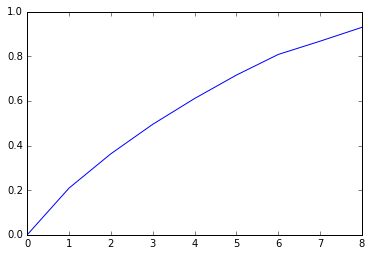

In [11]:
evals, evecs = np.linalg.eig(np.cov(x_trans.transpose()))

n_features_plot = [sum(sorted(evals[:i])) / sum(evals) for i in reversed(range(len(evals)))]

plt.plot([i for i in reversed(range(9))], n_features_plot)

Собственные трехмерные векторы

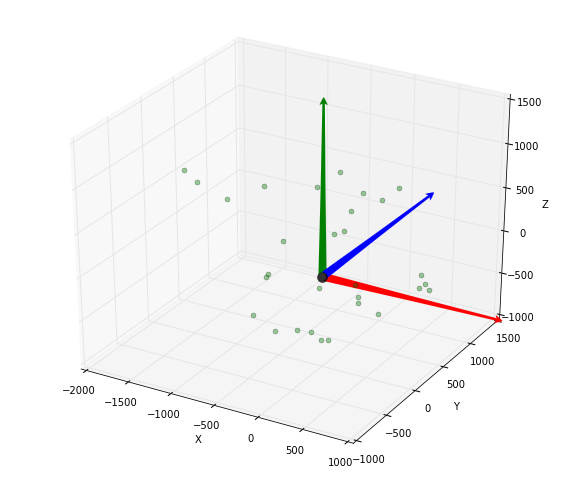

In [68]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

clf = PCA(n_components=3)
clf.fit(x)
x_trans = clf.transform(x)
evals, evecs = np.linalg.eig(np.cov(x_trans.transpose()))

mean_x = np.mean(x_trans[:,0])
mean_y = np.mean(x_trans[:,1])
mean_z = np.mean(x_trans[:,2])

ax.plot(x_trans[:,0][:30], x_trans[:,1][:30], x_trans[:,2][:30], 'o', markersize=5, color='g', alpha=0.4)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='black', alpha=0.8)

a = Arrow3D([mean_x, evecs[0][0] * 2000], [mean_y, evecs[0][1] * 2000], [mean_z, evecs[0][2] * 2000],
            mutation_scale=20, lw=0.05, arrowstyle="fancy", color="r")
ax.add_artist(a)
ax.set_xlabel('X')

b = Arrow3D([mean_x, evecs[1][0] * 2000], [mean_y, evecs[1][1] * 2000], [mean_z, evecs[1][2] * 2000],
            mutation_scale=20, lw=0.05, arrowstyle="fancy", color="g")
ax.add_artist(b)
ax.set_ylabel('Y')

c = Arrow3D([mean_x, evecs[2][0] * 2000], [mean_y, evecs[2][1] * 2000], [mean_z, evecs[2][2] * 2000],
            mutation_scale=20, lw=0.05, arrowstyle="fancy", color="b")
ax.add_artist(c)
ax.set_zlabel('Z')

plt.show()

In [96]:
trans_data = clf.transform(x)

In [25]:
trans_data[1]

array([-1701.4516848 ,   360.5515562 ,   501.80559391,   335.42365557,
        -442.37893255,   738.40404869,   653.87543763,  -176.60067741,
           7.52017489])

In [26]:
minpos = min(cov_mat.flat)

In [27]:
data_flat = []
for elem in cov_mat:
    temp = []
    for el in elem:
        temp.append(el + minpos)
    data_flat.append(temp)

Картинки для различных степеней сжатия

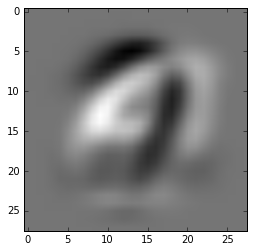

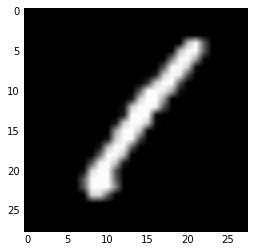

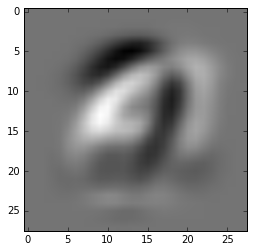

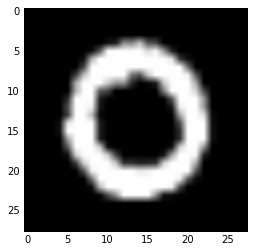

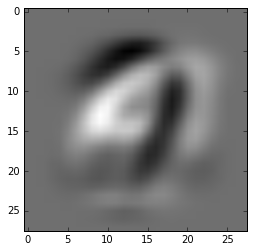

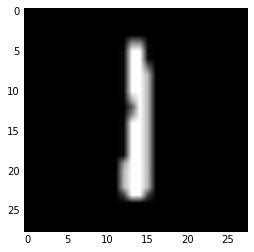

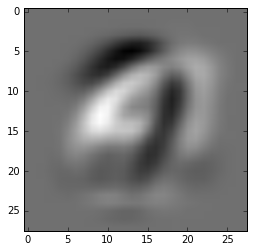

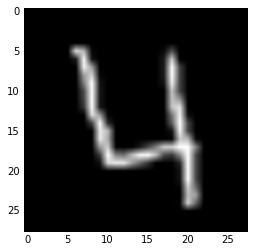

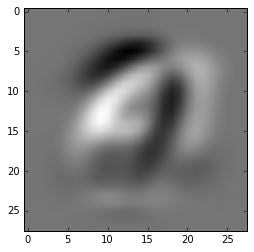

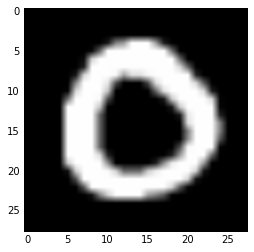

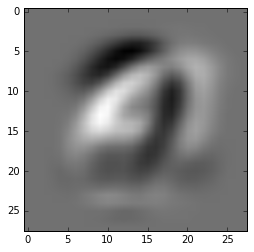

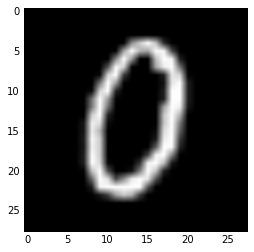

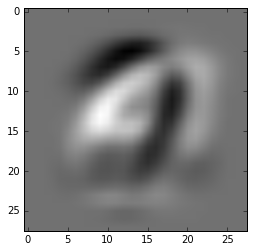

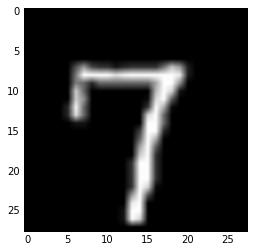

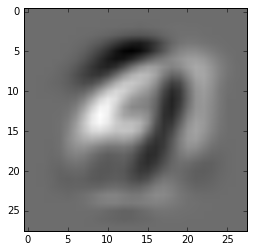

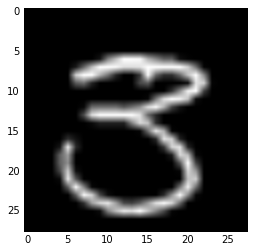

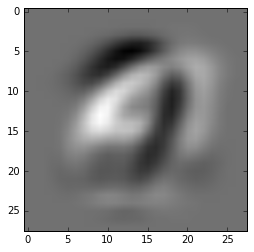

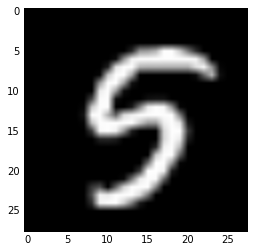

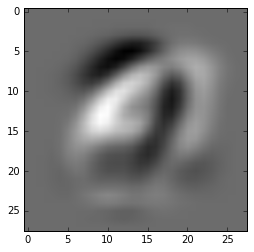

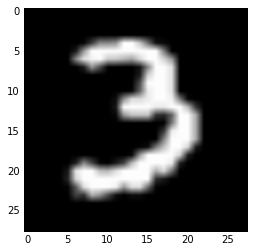

In [105]:
restored_data = clf.inverse_transform(trans_data)

for i in range(10):
    plt.figure()
    for j in range(len(trans_data[i])):
        trans_data[i][j] += min(trans_data[i])
    plt.imshow(restored_data[i].reshape(28,28), cmap='gray')
    plt.figure()
    plt.imshow(x[i].reshape(28,28), cmap='gray')

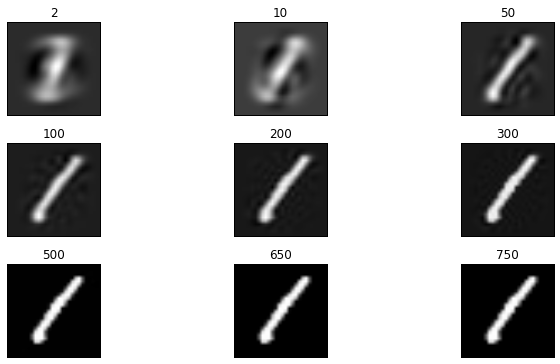

In [109]:
images = []
pca_number = [2, 10, 50, 100, 200, 300, 500, 650, 750]
for number in pca_number:
    clf = PCA(n_components=number)
    clf.fit(x)
    trans_data = clf.transform(x)

    restored_data = clf.inverse_transform(trans_data)
    
    images.append(restored_data[0])
    
fig, axes = plt.subplots(3, 3, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

i = 0
for ax, interp_method in zip(axes.flat, pca_number):
    ax.imshow(images[i].reshape(28,28), cmap='gray')
    ax.set_title(interp_method)
    i += 1
plt.show()


Поссмотрим на показания классификаторов

In [70]:
y = train_set['label']

In [71]:
clf = PCA(n_components=9)
clf.fit(x)
trans_data = clf.transform(x)

In [72]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(trans_data, y, test_size=0.2, random_state=0)

In [73]:
n_jobs = -1

print("Started to fitting KNN on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

accuracy_values = []
for number in range(1, 10):
    t0 = time()

    clf = neighbors.KNeighborsClassifier(number, n_jobs=n_jobs, weights='uniform')

    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    
    temp_acc = accuracy_score(y_test, y_predict)
    print('We have ', temp_acc, 'of accuracy on KNN with ', number, ' neighbor')
    accuracy_values.append(temp_acc)
    print("done in %0.3fs" % (time() - t0))
    print()

Started to fitting KNN on data with 8 cores...
We have  0.89880952381 of accuracy on KNN with  1  neighbor
done in 0.285s

We have  0.893928571429 of accuracy on KNN with  2  neighbor
done in 0.268s

We have  0.908928571429 of accuracy on KNN with  3  neighbor
done in 0.410s

We have  0.911071428571 of accuracy on KNN with  4  neighbor
done in 0.380s

We have  0.9125 of accuracy on KNN with  5  neighbor
done in 0.396s

We have  0.914642857143 of accuracy on KNN with  6  neighbor
done in 0.425s

We have  0.91369047619 of accuracy on KNN with  7  neighbor
done in 0.392s

We have  0.916666666667 of accuracy on KNN with  8  neighbor
done in 0.561s

We have  0.914880952381 of accuracy on KNN with  9  neighbor
done in 0.528s



Очень приятное быстродействие при умеренном снижении качества

In [75]:
n_jobs = -1

print("Started to fitting ExtraTreesClassifier on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

t0 = time()

forest = ExtraTreesClassifier(n_estimators=2000,
                              max_features=9,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X_train, y_train)

y_predict = forest.predict(X_test)

print('we have ', accuracy_score(y_test, y_predict), 'of accuracy on ExtraTreeClassifier')

print("done in %0.3fs" % (time() - t0))

Started to fitting ExtraTreesClassifier on data with 8 cores...
we have  0.908214285714 of accuracy on ExtraTreeClassifier
done in 25.417s


Попробуем нарисовать распределение

In [110]:
clf = PCA(n_components=2)
clf.fit(x)

PCA(copy=True, n_components=2, whiten=False)

In [115]:
plot_transform = clf.transform(x)

In [119]:
plot_transform = np.array(plot_transform)
#plt.scatter(plot_transform[])

In [121]:
scat_x = []
scat_y = []
for elem in plot_transform:
    scat_x.append(elem[0])
    scat_y.append(elem[1])

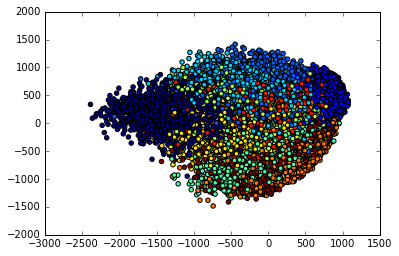

In [129]:
img = plt.scatter(scat_x,scat_y, c=y, alpha=1)
plt.savefig('2dplot.jpg')

In [78]:
clf = KernelPCA(n_components=10, kernel='poly', degree=2)
clf.fit(x)

MemoryError: 

Проблему с MemoryError победить так и не удалось,
на машине с 16гб оперативной памяти и 1.5тб выделенного свопа, испробованные различные ухищрения результата не дали =(
Поэтому дальше будем оперировать 10% данных для удобства и скорости

In [80]:
clf = KernelPCA(n_components=10, kernel='poly', degree=2)
clf.fit(x[:4200])

KernelPCA(alpha=1.0, coef0=1, degree=2, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='poly',
     kernel_params=None, max_iter=None, n_components=10,
     remove_zero_eig=False, tol=0)

In [81]:
kernelPCA_degree2_data = clf.transform(x[:4200])

In [83]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(kernelPCA_degree2_data, y[:4200],
                                                                             test_size=0.2, random_state=0)

In [84]:
n_jobs = -1

print("Started to fitting KNN on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

accuracy_values = []
for number in range(1, 10):
    t0 = time()

    clf = neighbors.KNeighborsClassifier(number, n_jobs=n_jobs, weights='uniform')

    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    
    temp_acc = accuracy_score(y_test, y_predict)
    print('We have ', temp_acc, 'of accuracy on KNN with ', number, ' neighbor')
    accuracy_values.append(temp_acc)
    print("done in %0.3fs" % (time() - t0))
    print()

Started to fitting KNN on data with 8 cores...
We have  0.853571428571 of accuracy on KNN with  1  neighbor
done in 0.662s

We have  0.842857142857 of accuracy on KNN with  2  neighbor
done in 0.146s

We have  0.855952380952 of accuracy on KNN with  3  neighbor
done in 0.168s

We have  0.863095238095 of accuracy on KNN with  4  neighbor
done in 0.127s

We have  0.860714285714 of accuracy on KNN with  5  neighbor
done in 0.123s

We have  0.860714285714 of accuracy on KNN with  6  neighbor
done in 0.120s

We have  0.859523809524 of accuracy on KNN with  7  neighbor
done in 0.121s

We have  0.854761904762 of accuracy on KNN with  8  neighbor
done in 0.126s

We have  0.857142857143 of accuracy on KNN with  9  neighbor
done in 0.135s



In [85]:
n_jobs = -1

print("Started to fitting ExtraTreesClassifier on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

t0 = time()

forest = ExtraTreesClassifier(n_estimators=2000,
                              max_features=9,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X_train, y_train)

y_predict = forest.predict(X_test)

print('we have ', accuracy_score(y_test, y_predict), 'of accuracy on ExtraTreeClassifier')

print("done in %0.3fs" % (time() - t0))

Started to fitting ExtraTreesClassifier on data with 8 cores...
we have  0.867857142857 of accuracy on ExtraTreeClassifier
done in 26.614s


Имеем ухудшение качества отноительно классического линейного PCA

Попробуем различные степени

In [88]:
acc_value_knn = []
acc_value_extrtr = []

for deg in log_progress(range(3, 10)):

    clf = KernelPCA(n_components=10, kernel='poly', degree=deg)
    clf.fit(x[:4200])
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(clf.transform(x[:4200]), y[:4200],
                                                                                 test_size=0.2, random_state=0)

    n_jobs = -1

    print("Started to fitting KNN on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

    accuracy_values = []
    
    for number in range(1, 10):
        t0 = time()

        clf = neighbors.KNeighborsClassifier(number, n_jobs=n_jobs, weights='uniform')

        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)

        temp_acc = accuracy_score(y_test, y_predict)
        print('We have ', temp_acc, 'of accuracy on KNN with ', number, ' neighbor')
        accuracy_values.append(temp_acc)
        print("done in %0.3fs" % (time() - t0))
        print()
        
    acc_value_knn.append(accuracy_values)

    n_jobs = -1

    print("Started to fitting ExtraTreesClassifier on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

    t0 = time()

    forest = ExtraTreesClassifier(n_estimators=2000,
                                  max_features=9,
                                  n_jobs=n_jobs,
                                  random_state=0)

    forest.fit(X_train, y_train)

    y_predict = forest.predict(X_test)
    
    score = accuracy_score(y_test, y_predict)
    
    acc_value_extrtr.append(score)

    print('we have ', score, 'of accuracy on ExtraTreeClassifier')

    print("done in %0.3fs" % (time() - t0))

Started to fitting KNN on data with 8 cores...
We have  0.836904761905 of accuracy on KNN with  1  neighbor
done in 0.123s

We have  0.832142857143 of accuracy on KNN with  2  neighbor
done in 0.117s

We have  0.845238095238 of accuracy on KNN with  3  neighbor
done in 0.137s

We have  0.84880952381 of accuracy on KNN with  4  neighbor
done in 0.117s

We have  0.839285714286 of accuracy on KNN with  5  neighbor
done in 0.132s

We have  0.853571428571 of accuracy on KNN with  6  neighbor
done in 0.121s

We have  0.853571428571 of accuracy on KNN with  7  neighbor
done in 0.130s

We have  0.847619047619 of accuracy on KNN with  8  neighbor
done in 0.120s

We have  0.840476190476 of accuracy on KNN with  9  neighbor
done in 0.149s

Started to fitting ExtraTreesClassifier on data with 8 cores...
we have  0.858333333333 of accuracy on ExtraTreeClassifier
done in 5.263s
Started to fitting KNN on data with 8 cores...
We have  0.802380952381 of accuracy on KNN with  1  neighbor
done in 0.146s


Посмотрим на качество при различных степенях ядра для KNN

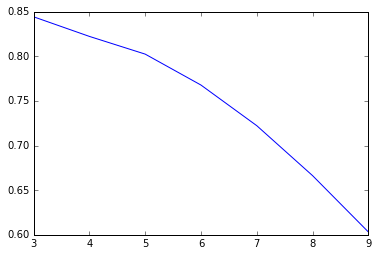

In [91]:
plt.plot([i for i in range(3,10)],[np.mean(acc_value_knn[i]) for i in range(7)])

Как видно, с ростом степени ядра имеем только ухудшение для метода ближайших соседей

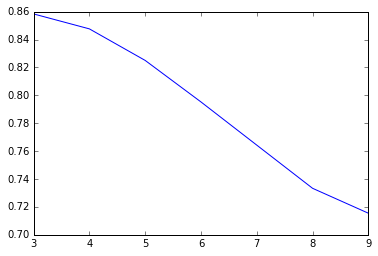

In [93]:
plt.plot([i for i in range(3,10)], acc_value_extrtr)

Аналогичные показатели для леса решающих деревьев

Попробуем Гауссову радиальную базисную функцию

In [94]:
clf = KernelPCA(n_components=10, kernel='rbf')
clf.fit(x[:4200])
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(clf.transform(x[:4200]), y[:4200],
                                                                             test_size=0.2, random_state=0)

n_jobs = -1

print("Started to fitting KNN on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

accuracy_values = []

for number in range(1, 10):
    t0 = time()

    clf = neighbors.KNeighborsClassifier(number, n_jobs=n_jobs, weights='uniform')

    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)

    temp_acc = accuracy_score(y_test, y_predict)
    print('We have ', temp_acc, 'of accuracy on KNN with ', number, ' neighbor')
    accuracy_values.append(temp_acc)
    print("done in %0.3fs" % (time() - t0))
    print()

n_jobs = -1

print("Started to fitting ExtraTreesClassifier on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

t0 = time()

forest = ExtraTreesClassifier(n_estimators=2000,
                              max_features=9,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X_train, y_train)

y_predict = forest.predict(X_test)

score = accuracy_score(y_test, y_predict)

print('we have ', score, 'of accuracy on ExtraTreeClassifier')

print("done in %0.3fs" % (time() - t0))

Started to fitting KNN on data with 8 cores...
We have  0.107142857143 of accuracy on KNN with  1  neighbor
done in 0.119s

We have  0.102380952381 of accuracy on KNN with  2  neighbor
done in 0.114s

We have  0.0964285714286 of accuracy on KNN with  3  neighbor
done in 0.129s

We have  0.0988095238095 of accuracy on KNN with  4  neighbor
done in 0.123s

We have  0.107142857143 of accuracy on KNN with  5  neighbor
done in 0.129s

We have  0.104761904762 of accuracy on KNN with  6  neighbor
done in 0.121s

We have  0.109523809524 of accuracy on KNN with  7  neighbor
done in 0.134s

We have  0.113095238095 of accuracy on KNN with  8  neighbor
done in 0.119s

We have  0.117857142857 of accuracy on KNN with  9  neighbor
done in 0.126s

Started to fitting ExtraTreesClassifier on data with 8 cores...
we have  0.0964285714286 of accuracy on ExtraTreeClassifier
done in 5.849s


Имеем просто ужасное качество, но хорошую скорость =(